In [2]:
import matplotlib.pyplot as plt
from generate_data import generate_data
from sklearn.model_selection import train_test_split
import numpy as np
from myMLlib import set_seed, TinyClassifier,rebalance_weight, plt_confusion, plt_loss,load_feather
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import torch
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader
from pymor.vectorarrays.numpy import NumpyVectorSpace
from training import batch_train
import yaml

In [3]:
with open('hyperparameters.yml', 'r') as file:
    all_parameters = yaml.safe_load(file)
    parameters = all_parameters['real-blood-meat-time']
materials = parameters['materials']
realmater = parameters['realmater']
materials = list(materials.values())
print(materials)
print(realmater)

['Vessel', 'Tissue']
['Silicone/Water', 'Silicone']


In [4]:
folderpath= ('/home/yuqster/files/research/dataset/realtest1',
             '/home/yuqster/files/research/dataset/realtest2',
             '/home/yuqster/files/research/dataset/realtest3',
             '/home/yuqster/files/research/dataset/realtest4',
             '/home/yuqster/files/research/dataset/realtest5',
             )
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 14
})
material = []

In [12]:
import pandas as pd
import random
import os

def load_feather_TS(folderpath, materials, N=None, rand = False):
    # 如果调用时没有传入 N，就根据 folderpath 的长度生成一个全是 3e5 的列表
    if N is None:
        N = [3e5] * len(folderpath)
    N = [int(x) for x in N]
    data_list = []
    labels = []
    for j, folder in enumerate(folderpath):
        data_list.append([])   # 动态创建子列表
        labels.append([])      # 同上
        files = os.listdir(folder)
        if rand:
            random.shuffle(files)
        if len(files) > N[j]:
            files = files[0:N[j]]
        for i in range(len(materials)):
            matching_files = [f for f in files if materials[i] in f]
            for path in matching_files:
                data = pd.read_feather(f'{folder}/{path}')
                trans = data.values
                if 'rep-0' in path:
                    little_list = [trans]
                else:
                    little_list.append(trans)
                if 'rep-0' in path:
                    data_list[j].append(little_list)
                    labels[j].append(i)
    return data_list, labels

In [13]:
seed = 43
set_seed(seed)
data_list,labels = load_feather_TS(folderpath,materials,[5e4 , 5e4, 2e4, 2e4, 2e4], rand=False)

UnboundLocalError: cannot access local variable 'little_list' where it is not associated with a value

In [9]:
a = np.array(data_list[0])
print(a.shape)
print(len(data_list[0]))

(50000, 4096, 1)
50000


In [7]:
snapshot = np.array(data_list[0]+data_list[1]+ data_list[2]+ data_list[3]).squeeze()
y = np.array(labels[0]+ labels[1]+ labels[2]+ labels[3]).reshape(-1,1)
snapshot_r = np.array(data_list[4]).squeeze()
y_r = np.array(labels[4]).reshape(-1,1)
print(snapshot.shape)
print(y.shape)
print(snapshot_r.shape)
print(y_r.shape)


(140000, 4096)
(140000, 1)
(20000, 4096)
(20000, 1)


In [3]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state=42)
print(Xtrain.shape)
print(ytrain.shape)

(150, 10, 50)
(150, 1)


In [4]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [5]:
# Split data into train and test sets


# X_train = scale(Xp_train,axis=1)
# X_test = scale(Xp_test,axis=1)
# X_r_test = scale(Xp_r,axis=1)
scaler = StandardScaler()
# scaler = RobustScaler(unit_variance=False)
_, T, C = Xtrain.shape
Xtrain = Xtrain.reshape(Xtrain.shape[0],-1)
Xtest = Xtest.reshape(Xtest.shape[0],-1)
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)
Xtrain = Xtrain.reshape(-1,T,C)
Xtest = Xtest.reshape(-1,T,C)
# X_r_test = scaler.transform(Xp_r)
# joblib.dump(scaler,'/Users/stonyxiong/files/Research/models/bloodmeat_time_scaler.save')

In [6]:
model = TinyClassifier(Xtrain.shape[-1],num_heads=2).to(device)
class_weights,_ = rebalance_weight(ytrain)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters())

In [7]:
X_train_tensor = torch.tensor(Xtrain, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(ytrain, dtype=torch.long).squeeze().to(device)
X_test_tensor = torch.tensor(Xtest, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(ytest, dtype=torch.long).squeeze().to(device)
print(y_test_tensor.shape)

torch.Size([50])


In [8]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
verify_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader  = DataLoader(train_dataset, batch_size=300, shuffle=True)
verify_loader = DataLoader(verify_dataset, batch_size=100, shuffle=False)

In [9]:
model,train_losses,verify_losses = batch_train(
                                        model=model,num_epochs=1000,
                                        criterion=criterion,
                                        optimizer=optimizer,
                                        train_loader=train_loader,
                                        verify_loader=verify_loader
                                    )

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(ytrain,predicted_np_train)
    accuracy = accuracy_score(ytest, predicted_np)
    cm = confusion_matrix(ytest, predicted_np)

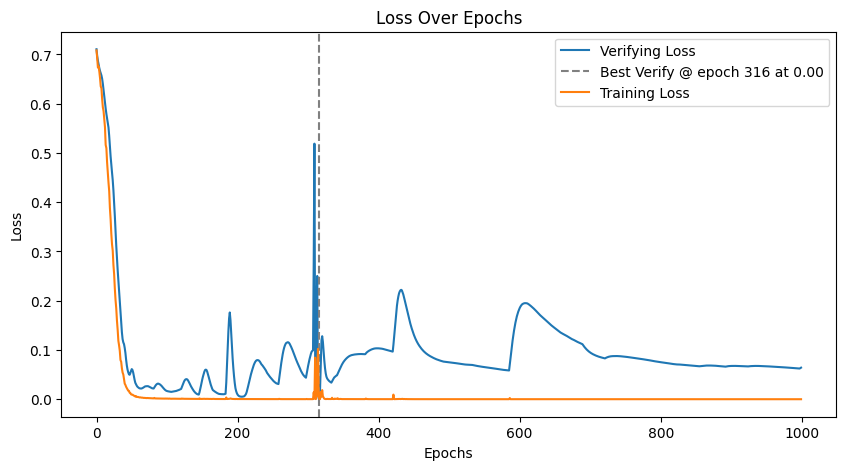

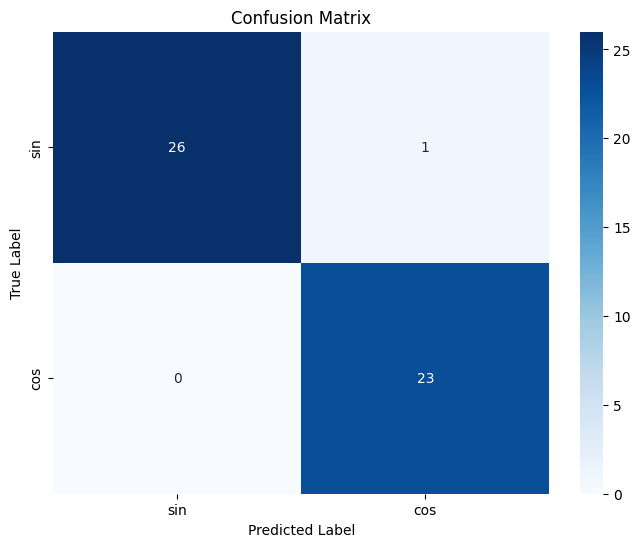

In [16]:
plt_loss(train_losses=train_losses,verifying_losses=verify_losses)
plt_confusion(cm, ['sin', 'cos'])